In [241]:
import numpy as np
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import math
import copy

In [277]:
df_distancias = pd.read_csv("../Datos/Caso II - Matriz de Distancias.csv", delimiter= ",", index_col= 0)
df_ubicacion_clientes = pd.read_csv("../Datos/Caso II - Ubicacion Clientes.csv", delimiter= ",")
datos_prueba = pd.read_csv("../Datos/Caso II - Set de Datos.csv", delimiter= ",", index_col= 0)

In [281]:
#Renombro las columnas de ubicacion Clientes
df_ubicacion_clientes = df_ubicacion_clientes.rename(columns={' Cliente ': 'Cliente',' Coord x ': 'X', ' Coord y ' : 'Y'})


In [333]:
column_mapping = {column_name: int(column_name) for column_name in datos_prueba.columns}
#Modifico el titulo de las columnas
datos_prueba.rename(columns=column_mapping, inplace=True)

In [334]:
#DEFINO LA MATRIZ LLEGA
def llega(x):
   return True if x <= 2 else False

df_llega = df_distancias.applymap(llega)

In [245]:
#DEFINIMOS CONSTANTES
#PROBLEMA
TARIFA_PROMEDIO = 1220
AHORRO = 0.05
TARIFA_OBJETIVO = TARIFA_PROMEDIO * (1-AHORRO)
CANTIDAD_DE_CLIENTES_POR_CAMION = 3
CANTIDAD_DE_CAMIONES = 6
TONS_MAX_POR_CAMION = 12
TARIFA_PROMEDIO = 1220
TARIFA_ESTRATO1 = 1400
TARIFA_ESTRATO2 = 1200
TARIFA_ESTRATO3 = 1000
AFORO_MINIMO = 5600
OCIOSIDAD = 5000
COSTO_TON_NO_RUTEADA = 3000

In [246]:
#METAHEURISTICA
T_INICIAL = 3000
T_FINAL = 1000
DELTA_T = -10
ITERACIONES_POR_TEMPERATURA = 50


In [247]:
#FUNCIONES
#generarSolucionInicial
def generarSolucionInicial(pedidos): #PEDIDOS ES UNA PANDAS SERIES CON LOS PEDIDOS
    #-----------------------CAMBIAR DATOS_PRUEBA 2 ----------------------------------------------------------------------
    pedidos = pedidos[pedidos > 0 ].index #Elimina los clientes con 0 toneladas y toma el index(Nombre de los clientes)
    pedidos = pedidos.to_list() #Lo convierte a lista
    pedidos.pop() #Elimino el ultimo (el total)
    pedidos_por_asignar = pedidos #Asigno todos lo pedidos a pedidos por asignar
    clientes_por_camion = [[] for _ in range(CANTIDAD_DE_CAMIONES)] #Armo la lista con los pedidos de los camiones por cliente
    pedidos_no_asignados = [] #Inicializo un lista con pedidos no asignados
    cantidad_clientes = len(pedidos_por_asignar) 
    for i in range(cantidad_clientes): #Recorro toda la lista de clientes para ese dia
        cliente = pedidos_por_asignar.pop() #Elimino el ultimo cliente de la lista de clientes a la vez que le asigno el cliente eliminado a la variable cliente
        rand = random.randint(0, CANTIDAD_DE_CAMIONES-1) #genero un numero aleatorio entero del 0 al 5
        camion_cliente = clientes_por_camion[rand] #Elijo el camion al aleatoriamente
        cantidad_clientes = len(camion_cliente)
        if cantidad_clientes < CANTIDAD_DE_CLIENTES_POR_CAMION: #Verifico que el camion no tenga 3 clientes
            llega_list = []
            for cliente_en_camion in camion_cliente:
                llega = df_llega.loc[cliente_en_camion,cliente]
                llega_list.append(llega)
            llega_todos = all(llega_list) #Si da 0 es decir que hay al menos un false, entonces no llega a todos
            if(llega_todos):
                clientes_por_camion[rand].append(cliente)
            else:
                pedidos_no_asignados.append(cliente)
        else:
            pedidos_no_asignados.append(cliente)
    return clientes_por_camion, pedidos_no_asignados #Devuelve dos listas ej: ([['A', 'B'],['J', 'H','D'] ] ['C','E','F'])


#--------------------------------------------------------------------------------------------------------------------


def pedidosPorCamion(clientes_por_camion, pedidos): #RECIBE UNA LISTA Y UN A PANDAS.SERIES DEVUELVE UNA LIST DE SERIES
    pedidos_por_camion = []
    for camion in clientes_por_camion: #Recorro los clientes por camion
            pedido = pedidos[camion] #Selecciono los pedidos de ese cliente(las tons)
            pedidos_por_camion.append(pedido)
    return pedidos_por_camion #Una lista de pandas.Series


#----------------------------------------------------------------------------------------------------------------------


#Calcular costo de la solucion
def tonsRepartidasPorCamion(pedidos_por_camion): #RECIBE UNA LIST DE SERIES Y DEVULEVE UNA LISTA DE NUMEROS
    tons = 0
    tons_repartidas_por_camion = []
    toneladas_no_repartidas = 0
    for pedido in pedidos_por_camion:
        tons = pedido.values.sum()
        if(tons <= TONS_MAX_POR_CAMION):
            tons_repartidas_por_camion.append(tons)
        else:
            tons_repartidas_por_camion.append(TONS_MAX_POR_CAMION)
            toneladas_no_repartidas += tons-TONS_MAX_POR_CAMION
    return tons_repartidas_por_camion, toneladas_no_repartidas


#--------------------------------------------------------------------------------------------------------------------------


#SUPER OK
def costoPorCamion(tons_repartidas_por_camion):
    costo_por_camion = []
    for tons in tons_repartidas_por_camion:
        costo = float(0)
        if (tons == 0):
            costo = 5000
        elif (tons < 4):
            costo = 5600
        elif (tons < 6.5):
            costo = tons * 1400
        elif (tons < 9.5):
            costo = tons * 1200
        else:
            costo = tons * 1000
        costo_por_camion.append(costo)
    return costo_por_camion


#-------------------------------------------------------------------------------------------------------------------------------------


def tonsNoAsignadas(pedidos_no_asignados, pedidos):
    return pedidos[pedidos_no_asignados].values.sum()

def costoTotal(costo_por_camion, tons_no_asignadas_o_no_repartidas):
    costo_total = sum(costo_por_camion) + tons_no_asignadas_o_no_repartidas * 3000
    return costo_total

def tonsRepartidas(tons_repartidas_por_camion):
    tons_repartidas = sum(tons_repartidas_por_camion)
    return tons_repartidas


In [248]:
def calcularCostoPorTon(cpc, cna, pedidos):
    #GENERA LOS PEDIDOS POR CAMION los pedidos(lista de Series) a partir de los clientes(lista de listas)
    pedidos_por_camion = []
    for camion in cpc: #Recorro los clientes por camion
            pedido = pedidos[camion] #Selecciono los pedidos de ese cliente(las tons)
            pedidos_por_camion.append(pedido)
    tons = 0
    tons_repartidas_por_camion = []
    

    #Calcula las toneladas que puede llevar cada camion y las que no
    tons_no_repartidas = 0
    for pedido in pedidos_por_camion:
        tons = pedido.values.sum()
        if(tons <= TONS_MAX_POR_CAMION):
            tons_repartidas_por_camion.append(tons)
        else:
            tons_repartidas_por_camion.append(TONS_MAX_POR_CAMION)
            tons_no_repartidas += tons-TONS_MAX_POR_CAMION
    
    #CALCULA EL COSTO A PARTIR DE LAS TONELADAS
    costo_por_camion = []
    for tons in tons_repartidas_por_camion:
        costo = float(0)
        if (tons == 0):
            costo = OCIOSIDAD
        elif (tons < 4):
            costo = AFORO_MINIMO
        elif (tons < 6.5):
            costo = tons * TARIFA_ESTRATO1
        elif (tons < 9.5):
            costo = tons * TARIFA_ESTRATO2
        else:
            costo = tons * TARIFA_ESTRATO3
        costo_por_camion.append(costo)
    
    #CALCULA LAS TONS REPARTIDAS
    tons_repartidas = sum(tons_repartidas_por_camion)
    
    #CALCULA LAS TONS NO ASIGNADAS
    tons_no_asignadas = pedidos[cna].values.sum()

    #CALCULA EL TOTAL DE LAS TONS NO ASIGNADAD O REPARTIDAS
    tons_no_asignadas_o_no_repartidas = tons_no_asignadas + tons_no_repartidas

    #CALCULA EL COSTO TOTAL
    costo_total = sum(costo_por_camion) + tons_no_asignadas_o_no_repartidas * COSTO_TON_NO_RUTEADA

    #CALCULA EL COSTO POR TON
    costo_por_ton = costo_total/tons_repartidas
    
    return costo_por_ton


In [249]:
def generarVecino1(clpc, clpa): #Recibe una list de lists y una list
    cpc = copy.deepcopy(clpc)
    cpa = copy.deepcopy(clpa)
    #---------SACA UN PEDIDO POR CAMION----------

    for clientes_por_camion_i in cpc:
        len_i = len(clientes_por_camion_i) #Veo cuantos pedidos tiene el camion
        if(len_i > 0):
            rand = random.randint(0, len_i-1) #Selecciono el pedido a cambiar
            cliente_eliminado = clientes_por_camion_i.pop(rand)
            #print("Cliente eliminado: ", cliente_eliminado)
            cpa.append(cliente_eliminado)
    
    #------AGREGA LOS PEDIDOS ALEATORIAMENTE A LOS CAMIONES------

    pna = []
    cantidad_pedidos_por_asignar = len(cpa)
    for i in range(cantidad_pedidos_por_asignar):
        cliente_a_asignar = cpa.pop()
        rand = random.randint(0, CANTIDAD_DE_CAMIONES-1)
        camion = cpc[rand]
        cantidad_clientes = len(camion)
        if  cantidad_clientes < CANTIDAD_DE_CLIENTES_POR_CAMION:
            llega_list = []
            for cliente_en_camion in camion:
                llega = df_llega.loc[cliente_en_camion,cliente_a_asignar]
                llega_list.append(llega)
            llega_todos = all(llega_list)
            if(llega_todos):
                cpc[rand].append(cliente_a_asignar)
            else:
                pna.append(cliente_a_asignar)
        else:
            pna.append(cliente_a_asignar)
    return  cpc, pna #Devuelve una list de lists y una list



In [250]:
def recocidoSimulado1(pedidos):
    t_start = time.time()
    clientes_por_camion_min = []
    pedidos_no_asignados_min = []
    costo_por_ton_repartida_min = float('inf')
    pedidos_no_asignados = None

    #GENERO SOLUCION INICIAL
    clientes_por_camion_1, pedidos_no_asignados_1 = generarSolucionInicial(pedidos)

    #CALCULO EL COSTO POR TON
    #cptr costo por tonelada repartida
    costo_por_ton_repartida_1 = calcularCostoPorTon(clientes_por_camion_1, pedidos_no_asignados_1, pedidos)
    
    #ASIGNO LOS CLIENTES POR CAMION, LOS CLIENTES NO ASIGNADOS, Y EL COSTO POR TON REPARTIDA
    clientes_por_camion_min = clientes_por_camion_1
    pedidos_no_asignados_min = pedidos_no_asignados_1
    costo_por_ton_repartida_min = costo_por_ton_repartida_1

    list_costo_temp_min = [costo_por_ton_repartida_min]
    list_costo_tiempo_min = [costo_por_ton_repartida_min]
    t_sol_inicial = time.time()
    list_tiempo = [t_sol_inicial - t_start]
    for t in range(T_INICIAL, T_FINAL, DELTA_T):

        for n in range(ITERACIONES_POR_TEMPERATURA):
            #GENERO SOLUCION INICIAL
            clientes_por_camion, pedidos_no_asignados = generarVecino1(clientes_por_camion_1, pedidos_no_asignados_1)

            #CALCULO EL COSTO POR TON
            costo_por_ton_repartida = calcularCostoPorTon(clientes_por_camion, pedidos_no_asignados, pedidos)
            
            #PROCESO DE DECISION
            delta = costo_por_ton_repartida_1 - costo_por_ton_repartida #Calculo delta como Sa - Sb

            #SOLUCION PEOR QUE EN LA ITERACION ANTERIOR
            if delta < 0 : #Si la solucion nueva es peor que la anterio delta < 0
                
                p = math.e**(delta/t)
                rand_0_1 = random.random()

                if p > rand_0_1 :

                    costo_por_ton_repartida_1 = costo_por_ton_repartida
                    pedidos_no_asignados_1 = pedidos_no_asignados
                    clientes_por_camion_1 = clientes_por_camion
            
            #SOLUCION MEJOR QUE EN LA ITERACION ANTERIOR
            else:
                #ACEPTA LA SOLUCION MEJOR
                costo_por_ton_repartida_1 = costo_por_ton_repartida
                pedidos_no_asignados_1 = pedidos_no_asignados
                clientes_por_camion_1 = clientes_por_camion

            if costo_por_ton_repartida_min > costo_por_ton_repartida:
                #ACTUALIZA A LA MEJOR SOLUCION HASTA AHORA
                costo_por_ton_repartida_min = costo_por_ton_repartida
                clientes_por_camion_min = clientes_por_camion
                pedidos_no_asignados_min = pedidos_no_asignados
                temp_sol = t
                t_iteracion = time.time()
                list_tiempo.append(t_iteracion - t_start)
                list_costo_tiempo_min.append(costo_por_ton_repartida_min)

        list_costo_temp_min.append(costo_por_ton_repartida_min)   
    return clientes_por_camion_min, pedidos_no_asignados_min, costo_por_ton_repartida_min, list_costo_temp_min, list_tiempo, list_costo_tiempo_min, temp_sol
    

In [251]:
def opt_2_bis(cpc, cna, costo_min, pedidos):
    cpc_min = copy.deepcopy(cpc)
    todos_camiones_con_pedidos = all(cpc)
    if not todos_camiones_con_pedidos:
        return cpc, costo_min
    
    solucion_mejor = True
    while(solucion_mejor):
        solucion_mejor = False
        #RECORRO TODOS LOS CAMIONES
        for i in range(CANTIDAD_DE_CAMIONES):

            camion_1 = cpc[i]
            len_camion_1 = len(camion_1)

            #RECORRO TODOS LOS CAMIONES PERO CAMION_1<CAMION_2
            for j in range(i+1,CANTIDAD_DE_CAMIONES):
                camion_2 = cpc[j]
                len_camion_2 = len(camion_2)
                
                #RECORRO TODOS LOS CLIENTES DEL CAMION_1
                for k in range(len_camion_1):
                    cliente_1 = copy.deepcopy(camion_1[k])


                    #GENERO EL ITERABLE PARA EL CLIENTE_2 SOBRE EL CAMION_1
                    # cm =  [m for m in range(0, len_camion_1) if m != k]

                    #RECORRO TODOS LOS CLIENTES DEL CAMION_2
                    for l in range(len_camion_2):
                        cliente_2 = copy.deepcopy(camion_2[l])
                        
                        #GENERO EL ITERABLE PARA EL CLIENTE_1
                        cn = [n for n in range(0,len_camion_2) if n != l]
                        
                        #QUIERO METER AL CLIENTE_1 EN EL CAMION_2
                            #ME FIJO SI DA LA DISTANCIA PARA TODOS LOS CLIENTES QUE HAY EN CAMION_2 MENOS CON EL QUE VOY A INTERCAMBIA (CLIENTE_2)
                        llega_list_1 =[]
                        for n in cn:
                            cliente = camion_2[n]
                            llega_1 = df_llega.loc[cliente_1,cliente]
                            llega_list_1.append(llega_1)
                        
                        llega_todos_1 = all(llega_list_1) #Chequea que sean todos true
                        
                        #SI EL CLIENTE_1 ES COMPATIBLE CON LOS CLIENTES DEL CAMION_2 PRUEBO EL CLIENTE_2 EN EL CAMION_1
                        if(llega_todos_1):

                            cm = [n for n in range(0, len_camion_1) if n != k]
                            llega_list_2 = []
                            
                            for m in cm:
                                cliente = camion_1[m]
                                llega_2 = df_llega.loc[cliente_2, cliente]
                                llega_list_2.append(llega_2)
                            llega_todos_2 = all(llega_list_2)
                            
                            
                            #SI EL CLIENTE_2 ENTRA EN EL CAMION_1 LOS CAMBIO
                            if(llega_todos_2):
                                # print("----llega todos entra al if----")
                                # print(cpc)
                                # print("camion_1:", i)
                                # print("camion_2:", j)
                                # print("k:", k)
                                # print("l:", l)
                                # print("cliente_1 a mover:", camion_1[k])
                                # print("cliente_2 a mover:", camion_2[l])
                                del camion_1[k]
                                del camion_2[l]

                                camion_1.insert(k,cliente_2)
                                camion_2.insert(l,cliente_1)

                                #CALCULAR COSTO
                                costo = calcularCostoPorTon(cpc, cna, pedidos)
                                #print("Clientes cambiados:", cpc)
                                #IF COSTO_MIN < COSTO
                                if costo_min > costo:
                                    cpc_min = copy.deepcopy(cpc)
                                    costo_min = costo
                                    solucion_mejor = True                               

                                del camion_1[k]
                                del camion_2[l]

                                camion_1.insert(k,cliente_1)
                                camion_2.insert(l,cliente_2)
                                # print("----rearma los clientes al original----")
                                # print(cpc)
                                

    #Retorno los clientes por camion
    return cpc_min, costo_min

In [252]:
def refino1(cpc,cna,pedidos):
    
    for clna in reversed(cna):
        for j, camion in enumerate(cpc):
            cantidad_clientes = len(camion)
            
            llega_list = []
            for cliente in camion:
                llega_2 = df_llega.loc[cliente,clna]
                llega_list.append(llega_2)
            llega_todos = all(llega_list)

            tons = pedidos[camion].values.sum()

            if(cantidad_clientes < CANTIDAD_DE_CLIENTES_POR_CAMION and llega_todos and tons < TONS_MAX_POR_CAMION):
                camion.append(clna)
                cna.remove(clna)
                break
    
    costo_por_ton = calcularCostoPorTon(cpc, cna, pedidos)
    
    return cpc, cna, costo_por_ton


In [253]:
#OPTIMIZADOR, JUNTO LAS 3 FUNCIONES RECOCIDO SIMULADO, REFINO, 2_OPT
def optimizador(pedidos):

    inicio = time.time()

    #RECOCIDO SIMULADO
    clientes_por_camion_min, clientes_no_asignados_min, costo_por_ton_repartida_recocido_min, list_costo_temp_min, list_tiempo, list_costo_tiempo_min, temp_sol =  recocidoSimulado1(pedidos)
    fin_recocido = time.time()
    print("-- Recocido Simulado Finalizado --", f"{fin_recocido-inicio:.2f}" )

    #REFINADO
    clientes_por_camion_min, clientes_no_asignados_min, costo_por_ton_repartida_refinado_min = refino1(clientes_por_camion_min, clientes_no_asignados_min, pedidos)
    fin_refinado = time.time()
    list_tiempo.append(fin_refinado-inicio)
    list_costo_tiempo_min.append(costo_por_ton_repartida_refinado_min)
    print("-- Refinado terminado --", f"{fin_refinado - fin_recocido:.2f}")

    #2-OPT
    costo_por_ton_repartida_min,costo_por_ton_repartida_min = opt_2_bis(clientes_por_camion_min, clientes_no_asignados_min, costo_por_ton_repartida_refinado_min, pedidos)
    fin_2_opt = time.time()
    list_tiempo.append(fin_2_opt-inicio)
    list_costo_tiempo_min.append(costo_por_ton_repartida_min)
    print("-- 2-OPT Finalizado --", f"{fin_2_opt - fin_refinado:.2f}")
    return clientes_por_camion_min, clientes_no_asignados_min, costo_por_ton_repartida_min, costo_por_ton_repartida_recocido_min, list_costo_temp_min, list_tiempo, list_costo_tiempo_min, temp_sol

In [254]:
#GENERAR DATAFRAME PARA ENTREGAS A PARTIR DE LA SOLUCION
def generarEntregable(clientes_por_camion_min, pedidos_no_asignados_min, pedidos):
    lista_de_pedidos = []
    cpc = clientes_por_camion_min
    cna = pedidos_no_asignados_min
    for i, camion in enumerate(cpc):
        for cliente in camion:
            tons = pedidos[cliente]
            new_row = {'Camion': i+1, 'Cliente': cliente, 'Tons pedidas': tons}
            lista_de_pedidos.append(new_row)
    for cliente in cna:
            tons = pedidos[cliente]
            new_row = {'Camion': 'No asignado', 'Cliente': cliente, 'Tons pedidas': tons}
            lista_de_pedidos.append(new_row)

    df_resultados = pd.DataFrame(lista_de_pedidos)



    df_resultados['Tons Entregadas'] = 0

    #Iterate over each row and calculate the Tons Entregadas while respecting the truck capacity
    current_truck = 1
    delivered_tons = 0
    for index, row in df_resultados.iterrows():
        tons = row['Tons pedidas']
        if current_truck != row['Camion']:
            current_truck = row['Camion']
            delivered_tons = 0
        if delivered_tons + tons <= TONS_MAX_POR_CAMION:
            df_resultados.at[index, 'Tons Entregadas'] = tons
            delivered_tons += tons
        else:
            df_resultados.at[index, 'Tons Entregadas'] = TONS_MAX_POR_CAMION - delivered_tons
            delivered_tons = TONS_MAX_POR_CAMION


    df_resultados['Tons No Entregadas'] = df_resultados.apply(lambda row: row['Tons pedidas'] - row['Tons Entregadas'] if row['Tons pedidas'] > row['Tons Entregadas'] else 0, axis=1)
    df_resultados.loc[df_resultados['Camion'] == "No asignado", 'Tons No Entregadas'] = df_resultados.loc[df_resultados['Camion'] == "No asignado", 'Tons pedidas']
    df_resultados.loc[df_resultados['Camion'] == "No asignado", 'Tons Entregadas'] = 0
    return df_resultados

In [337]:
#ESTÁ ARMADO PARA EL DATAFRAME DE PRUEBA PERO SE PUEDE PONER CUALQUIER COSA
DIA = 1
pedidos = datos_prueba[DIA]
clientes_por_camion_min, clientes_no_asignados_min, costo_por_ton_repartida_min, costo_por_ton_repartida_recocido_min, list_costo_temp_min, list_tiempo, list_costo_tiempo_min, temp_sol = optimizador(pedidos)



-- Recocido Simulado Finalizado -- 121.02
-- Refinado terminado -- 0.02
-- 2-OPT Finalizado -- 0.76


In [339]:
print("Mejor solución clientes por camion:",clientes_por_camion_min)
print("Mejor solución clientes no asignados:",clientes_no_asignados_min)
print("Mejor solución recocido simulado: ", f"{costo_por_ton_repartida_recocido_min:.2f}", "$/tonRepartida")
print("Mejor solución global", f"{costo_por_ton_repartida_min:.2f}", "$/tonRepartida" )

Mejor solución clientes por camion: [['M', 'A'], ['F', 'D', 'O'], ['G', 'H'], ['B', 'E'], ['I', 'K', 'N'], ['L', 'J']]
Mejor solución clientes no asignados: ['C']
Mejor solución recocido simulado:  1128.57 $/tonRepartida
Mejor solución global 1084.51 $/tonRepartida


In [345]:
#Genero el entregable
df_resultados = generarEntregable(clientes_por_camion_min, clientes_no_asignados_min, pedidos)

#EXPORTA EL DATAFRAME como CSV
df_resultados.to_csv('Resultados.csv')
df_resultados

,Camion,Cliente,Tons pedidas,Tons Entregadas,Tons No Entregadas
0,1,M,7,7,0
1,1,A,5,5,0
2,2,F,3,3,0
3,2,D,2,2,0
4,2,O,7,7,0
5,3,G,8,8,0
6,3,H,2,2,0
7,4,B,6,6,0
8,4,E,6,6,0
9,5,I,4,4,0


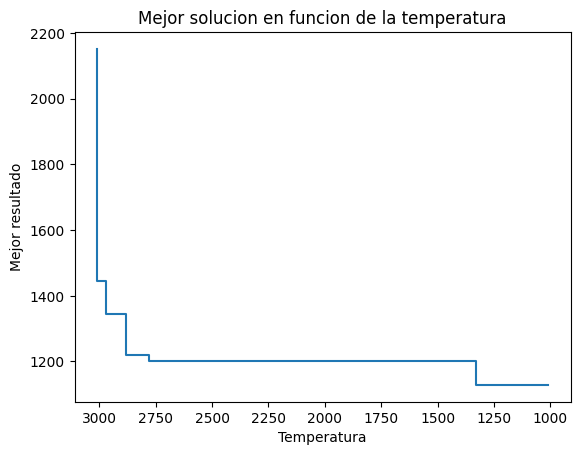

In [341]:

#plt.scatter(list(range(T_INICIAL-DELTA_T, T_FINAL, DELTA_T)), list_costo_temp_min)
plt.step(list(range(T_INICIAL-DELTA_T, T_FINAL, DELTA_T)), list_costo_temp_min)
plt.gca().invert_xaxis()
plt.xlabel("Temperatura")
plt.ylabel("Mejor resultado")
plt.title("Mejor solucion en funcion de la temperatura")
plt.show()

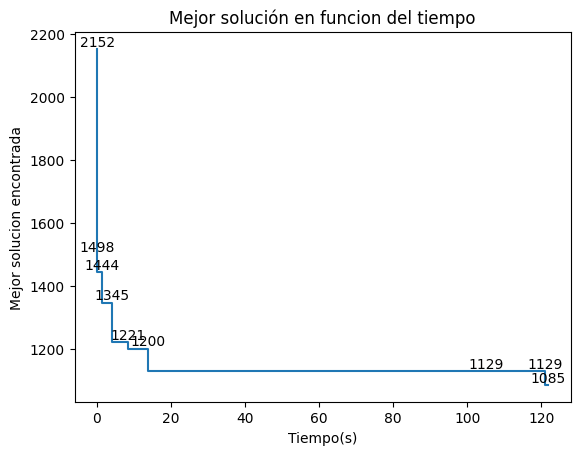

In [342]:
#PLOT: Mejor solucion vs tiempo
plt.step(list_tiempo, list_costo_tiempo_min )

for i in range(len(list_tiempo)):
    plt.text(list_tiempo[i], list_costo_tiempo_min[i], str(f"{list_costo_tiempo_min[i]:.0f}"), ha='center', va='bottom')
plt.xlabel("Tiempo(s)")
plt.ylabel("Mejor solucion encontrada")
plt.title("Mejor solución en funcion del tiempo")
plt.show()

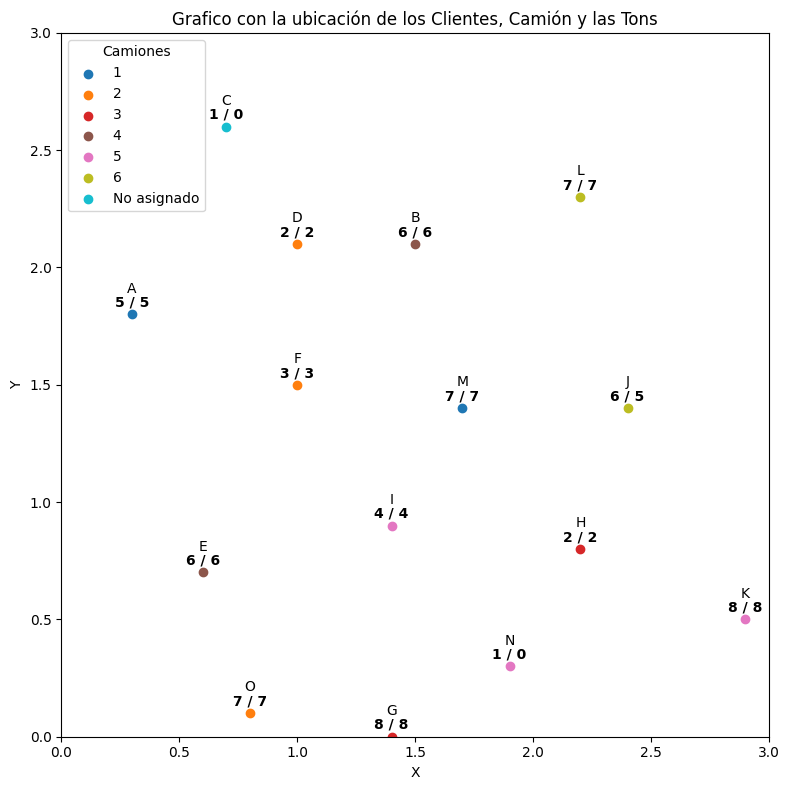

In [344]:
# Get unique camiones from the dataframe
camiones = df_resultados['Camion'].unique()
num_camiones = len(camiones)

# Create a color map for camiones
camion_colors = plt.cm.get_cmap('tab10', num_camiones)

# Merge the dataframes on 'Cliente' column
merged_df = df_resultados.merge(df_ubicacion_clientes, on='Cliente')

# Create a dictionary to map camiones to colors
camion_color_map = dict(zip(camiones, camion_colors(np.arange(num_camiones))))

plt.figure(figsize=(8, 8))

# Plot the scatter plot with colors
for camion in camiones:
    camion_data = merged_df[merged_df['Camion'] == camion]
    plt.scatter(camion_data['X'], camion_data['Y'], color=camion_color_map[camion])

# Add a colorbar legend
handles = [plt.scatter([], [], color=camion_color_map[camion]) for camion in camiones]
labels = [f'{camion}' for camion in camiones]
plt.legend(handles, labels, title='Camiones', loc='upper left')

# Add tons pedidas and tons entregadas as text to each point
for i in range(len(merged_df)):
    plt.text(merged_df['X'][i], merged_df['Y'][i] + 0.05, f"{merged_df['Tons pedidas'][i]} / {merged_df['Tons Entregadas'][i]}",
             ha='center', va='center', color='black', weight='bold')
    plt.text(merged_df['X'][i], merged_df['Y'][i] + 0.11, merged_df['Cliente'][i],
             ha='center', va='center', color='black')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Grafico con la ubicación de los Clientes, Camión y las Tons')
plt.yticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
plt.xticks([0, 0.5, 1, 1.5, 2, 2.5, 3])
plt.xlim(0,3)
plt.ylim(0,3)
# Adjust the layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()

